# Comparing FCC & CFPB Complaint Data

by Mark Silverberg ([@Skram](https://twitter.com/skram)) <mark.silverberg@socrata.com>

## Setup
### Dependencies and variables

In [232]:
### for data analysis
import pandas as pd
import numpy as np
import urllib

### for credentials
import json
with open('secrets.json') as data_file:    
    secrets = json.load(data_file)

### for plotly plotting
import plotly.plotly as py
py.sign_in(secrets["PLOTLY"]["USER"], secrets["PLOTLY"]["API_KEY"])

### for Census querying
from census import Census
from us import states
census = Census(secrets["CENSUS"]["API_KEY"]) # dummy API account

### for iPython displaying
from IPython.display import display, Image, HTML

## variables
variables = {
    "date_received":{
        "fcc":"ticket_created",
        "cfpb":"date_received"
    },
    "state":{
        "fcc":"state",
        "cfpb":"state"
    },
    "endpoint":{
        "fcc":"https://opendata.fcc.gov/resource/sr6c-syda.json",
        "cfpb":"https://data.consumerfinance.gov/resource/jhzv-w97w.json"
    }
}
provider_keys = variables['endpoint'].keys()

query_templates = { # always make sure there is a LIMIT statement with a {n} variable
    'count_by_state':{
        "template":"SELECT {0} as state, count(*) as complaints GROUP BY {0} LIMIT {1}",
        "variables":["state"]
    },
#     'count_by_month_and_state':{
#         "template":"SELECT {0} as state, date_trunc_ym({1}) as date_received, count(*) GROUP BY {0}, {1} ORDER BY date_received LIMIT {2}",
#         "variables":["state","date_received"]
#     }
}
query_template_keys = query_templates.keys()

a_big_number = 10000000 # for SODA query limits

### Helper functions

In [233]:
## function to marry a query template and provider's normalized variables into an API query string
def form_query_url(template,provider):
    base_url = variables['endpoint'][provider]
    query_template = query_templates[template]
    
    # form array of variables for the query template
    format_variables = []
    for variable in query_template['variables']:
        format_variables.append(variables[variable][provider])
    format_variables.append(a_big_number) 

    # put template and format_variables together
    query_str = query_template['template'].format(*format_variables)
    return "{0}?$query={1}".format(base_url, urllib.quote(query_str))

## function to create a plotly-powered US-state choropleth
def us_state_choropleth(df,col_to_color_by,units,title):
    plotly_data = [ dict(
        type='choropleth',
        autocolorscale = True,
        locations = df['state'],
        z = df[col_to_color_by],
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = units
        )
    ) ]
    plotly_layout = dict(
            title = title,
            geo = dict(
                scope='usa',
                projection=dict( type='albers usa' ),
            ),
        )
    fig = dict( data=plotly_data, layout=plotly_layout )
    return fig

## function used with df.apply to normalize count per 100,000 popualation
def normalize_for_pop(row):
    pop = state_population_lookup.get(row['state'], None)
    if pop != None:
        rate = (int(row['complaints']) / float(pop))*100000
    else:
#         print "** state={0} isnt in state_population_lookup and wont have a rate calculated for it".format(row['state'])
        rate = None
    return rate

## Fetch the data (for each query template and provider)

In [234]:
# fetch the data 

data = dict()

## fetch data for all query templates and providers
for template in query_template_keys:
    data[template] = {}
    for provider in provider_keys:
        url = form_query_url(template,provider)
        print "Fetching {0} for {1} at {2}".format(template,provider,url)
        data[template][provider] = pd.read_json(url)

Fetching count_by_state for cfpb at https://data.consumerfinance.gov/resource/jhzv-w97w.json?$query=SELECT%20state%20as%20state%2C%20count%28%2A%29%20as%20complaints%20GROUP%20BY%20state%20LIMIT%2010000000
Fetching count_by_state for fcc at https://opendata.fcc.gov/resource/sr6c-syda.json?$query=SELECT%20state%20as%20state%2C%20count%28%2A%29%20as%20complaints%20GROUP%20BY%20state%20LIMIT%2010000000


## Print some summary stats and raw count choropleths

In [235]:
images_to_display = []

print "Some summary data and graphics:"

template = 'count_by_state'
for provider in provider_keys:
    d = data[template][provider]
    print " - {0} for {1} has {2} rows for a total of {3} complaints".format(template, provider, len(d), d['complaints'].sum())

    fig = us_state_choropleth(d,'complaints','Number of Complaints','{0} Complaints by State'.format(provider.upper()))
    image_name = 'pyimage_{0}-{1}.png'.format(template, provider)
    py.image.save_as(fig, 'images/'+image_name)
    images_to_display.append(image_name)

counts_by_state_html = "<h2 style='text-align: center;'>Total # of Complaints per Data Source</h2><table><tr>"
for image_path in images_to_display:
    counts_by_state_html += '<td><img src="images/{0}" alt="{0}" /></td>'.format(image_path)
counts_by_state_html += "</tr></table>"

display(HTML(counts_by_state_html))

Some summary data and graphics:
 - count_by_state for cfpb has 63 rows for a total of 572997 complaints
 - count_by_state for fcc has 57 rows for a total of 488228 complaints


,


## Let's try normalizing complaint counts per 100k population

### First, get state populations from the US Census

In [236]:
## consistent with Census Fact Finder 'TOTAL POPULATION / Universe: Total population / 2009-2013 American Community Survey 5-Year Estimates'
pop_est_table_id = 'B01003_001E'
state_populations = census.acs.state(('NAME',pop_est_table_id), Census.ALL, year=2013) # http://1.usa.gov/1RAhxWq

## create lookup dictionary of population
state_population_lookup = dict()
for row in state_populations:
    state = states.lookup(row['state']).abbr
    pop = row[pop_est_table_id]
    state_population_lookup[state] = pop
    
print "Got population data for {0} 'states'".format(len(state_population_lookup))

Got population data for 52 'states'


### Plot normalized counts

In [238]:
# Normalized complaint counts per 100k population

images_to_display = []

template = 'count_by_state'
for provider in provider_keys:
    d = data[template][provider]
    d['complaint_rate_per_100k_pop'] = d.apply(normalize_for_pop, axis=1)

    fig = us_state_choropleth(d,'complaint_rate_per_100k_pop','Complaints Per 100k Pop.','{0} Complaints by State (per 100k population)'.format(provider.upper()))
    # py.iplot( fig, filename='d3-cloropleth-map' )
    image_name = 'pyimage_{0}-{1}-per100k.png'.format(template, provider)
    py.image.save_as(fig, 'images/'+image_name)
    images_to_display.append(image_name)

counts_by_state_html = "<h2 style='text-align: center;'>Normalized # of Complaints per 100k population per Data Source</h2><table><tr>"
for image_path in images_to_display:
    counts_by_state_html += '<td><img src="images/{0}" alt="{0}" /></td>'.format(image_path)
counts_by_state_html += "</tr></table>"

display(HTML(counts_by_state_html))

,


### Check out the top states by normalized complaint count

In [188]:
data['count_by_state']['fcc'].sort_values('complaint_rate_per_100k_pop', ascending=False).head(5)

,complaints,state,complaint_rate_per_100k_pop
8,2314,DC,373.604835
22,17308,MD,296.659462
6,11860,CO,231.670987
10,39827,FL,208.614921
52,14014,WA,205.496556


In [189]:
data['count_by_state']['cfpb'].sort_values('complaint_rate_per_100k_pop', ascending=False).head(5)

,complaints,state,complaint_rate_per_100k_pop
11,3332,DC,537.965129
12,3006,DE,330.894737
26,18256,MD,312.908200
13,55372,FL,290.040058
39,23139,NJ,261.978446


## Beginnings of playing with sentiment analysis

In [190]:
from textblob import TextBlob # read http://planspace.org/20150607-textblob_sentiment/ for a good overview

# fetch all CFPB complaints and their associated state
url = variables['endpoint']['cfpb']+"?$query="+urllib.quote("SELECT state, complaint_what_happened WHERE state IS NOT NULL AND complaint_what_happened IS NOT NULL LIMIT {0}".format(a_big_number))
all_cfpb = pd.read_json(url)
print len(all_cfpb)

74605


In [193]:
def sentiment_polarity(row):
    blob = TextBlob(row['complaint_what_happened'])
    blob_sentiment = blob.sentiment
    return blob_sentiment.polarity

def sentiment_subjectivity(row):
    blob = TextBlob(row['complaint_what_happened'])
    blob_sentiment = blob.sentiment
    return blob_sentiment.subjectivity

all_cfpb['polarity'] = all_cfpb.apply(sentiment_polarity, axis=1) # -1 to 1 (neg to pos)
all_cfpb['subjectivity'] = all_cfpb.apply(sentiment_subjectivity, axis=1) # 0 to 1 (_ to subjective)



In [198]:
# get average by state
cfpb_state_avgs = all_cfpb.groupby(['state']).mean()

# hacks because of Mark's pandas newbness
from StringIO import StringIO
csv = cfpb_state_avgs.to_csv()
CSV_DATA=StringIO(csv)
cfpb_state_avgs = pd.read_csv(CSV_DATA)

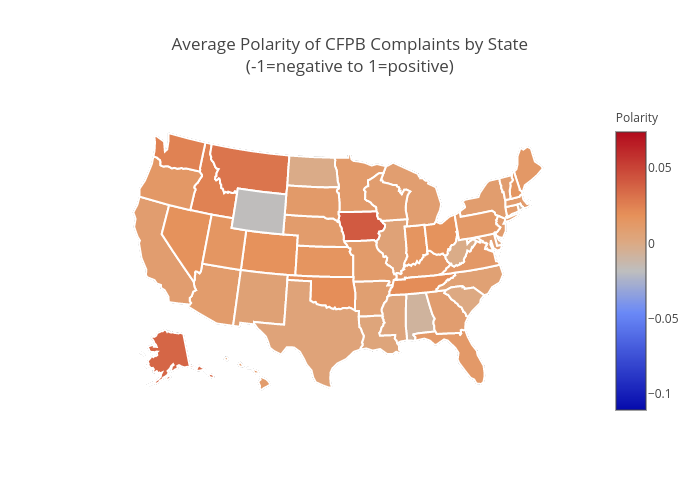

In [239]:
fig = us_state_choropleth(cfpb_state_avgs,'polarity','Polarity','Average Polarity of CFPB Complaints by State<br />(-1=negative to 1=positive)')
# py.iplot( fig, filename='d3-cloropleth-map' )
image_name = 'pyimage_count_by_state-cfpb-sentiment_polarity.png'
py.image.save_as(fig, 'images/'+image_name)
Image('images/'+image_name)

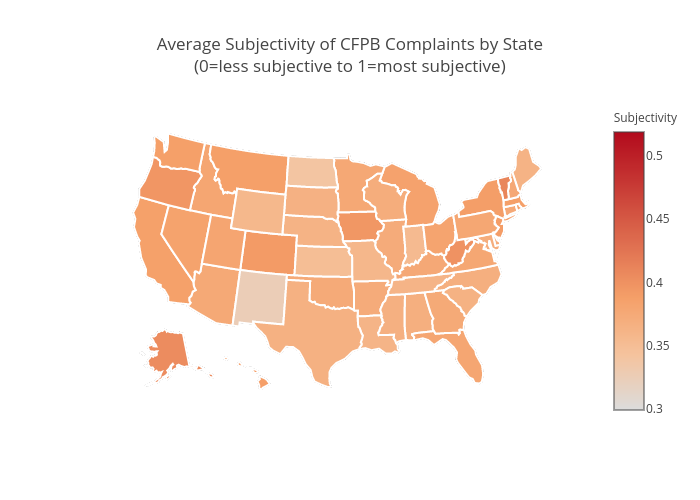

In [240]:
fig = us_state_choropleth(cfpb_state_avgs,'subjectivity','Subjectivity','Average Subjectivity of CFPB Complaints by State<br />(0=less subjective to 1=most subjective)')
# py.iplot( fig, filename='d3-cloropleth-map' )
image_name = 'pyimage_count_by_state-cfpb-sentiment_subjectivity.png'
py.image.save_as(fig, 'images/'+image_name)
Image('images/'+image_name)